##      Develop ML Prediction Model for early detection of Sepsis using MIMIC-III ICU Datasets

Sepsis is a life-threatening condition that occurs when the body's response to infection causes tissue damage, organ failure, or death (Singer et al., 2016). In the U.S., nearly 1.7 million people develop sepsis and 270,000 people die from sepsis each year; over one third of people who die in U.S. hospitals have sepsis (CDC). 
Internationally, an estimated 30 million people develop sepsis and 6 million people die from sepsis each year; an estimated 4.2 million newborns and children are affected (WHO). Sepsis costs U.S. hospitals more than any other health condition at $24 billion (13% of U.S. healthcare expenses) a year, and a majority of these costs are for sepsis patients that were not diagnosed at admission (Paoli et al., 2018). Sepsis costs are even greater globally with the developing world at most risk. Altogether, sepsis is a major public health issue responsible for significant morbidity, mortality, and healthcare expenses.

##### Dataset (https://mimic.mit.edu/docs/iii/)

MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising
deidentified health-related data associated with over forty thousand patients who stayed in critical care units
of the Beth Israel Deaconess Medical Center between 2001 and 2012.
The database includes information such as demographics, vital sign measurements made at the bedside
(~1 data point per hour), laboratory test results, procedures, medications, caregiver notes, imaging reports,
and mortality (both in and out of hospital).

In [125]:

import numpy as np
import pandas as pd
import psycopg2
import socket
import sys
import os
import getpass
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV 

In [15]:
#Reading the data
df=pd.read_csv(r'D:\Mostafa\Mimic\sepsis_mimic.csv')

In [16]:
df.head()

Unnamed: 0  hadm_id  sofa  sofaresp  sofacoag  sofaliv  sofacardio  \
0           0   100003     3       NaN       0.0      2.0         NaN   
1           1   100003     4       NaN       0.0      2.0         1.0   
2           2   100003     6       NaN       1.0      2.0         1.0   
3           3   100003     8       NaN       1.0      2.0         3.0   
4           4   100003     8       NaN       1.0      2.0         3.0   

   sofagcs  sofaren  h_from_admission  ... suspected_of_infection_poe  \
0      0.0      1.0                 0  ...                          1   
1      0.0      1.0                 1  ...                          1   
2      1.0      1.0                 2  ...                          1   
3      1.0      1.0                 3  ...                          1   
4      1.0      1.0                 4  ...                          1   

   suspected_infection_time_poe  suspected_infection_time_poe_days  \
0           2150-04-17 00:00:00                           0.649792   
1           2150-04-17 00:00:00                           0.649792   
2           2150-04-17 00:00:00                           0.649792   
3           2150-04-17 00:00:00                           0.649792   
4           2150-04-17 00:00:00                           0.649792   

   exclusion_secondarystay_inactive  exclusion_nonadult  exclusion_carevue  \
0                                 0                   0                  0   
1                                 0                   0                  0   
2                                 0                   0                  0   
3                                 0                   0                  0   
4                                 0                   0                  0   

   exclusion_suspicion_before_intime_inactive  \
0                                           1   
1                                           1   
2                                           1   
3                                           1   
4                                           1   

   exclusion_suspicion_after_intime_plus_4_inactive  exclusion_bad_data  \
0                                               NaN                   0   
1                                               NaN                   0   
2                                               NaN                   0   
3                                               NaN                   0   
4                                               NaN                   0   

   excluded  
0         0  
1         0  
2         0  
3         0  
4         0  

[5 rows x 45 columns]

In [13]:
df.shape

(1033007, 45)

In [12]:
print(df.dtypes)

Unnamed: 0                                            int64
hadm_id                                               int64
sofa                                                  int64
sofaresp                                            float64
sofacoag                                            float64
sofaliv                                             float64
sofacardio                                          float64
sofagcs                                             float64
sofaren                                             float64
h_from_admission                                      int64
sepsis_time                                          object
h_in_SI_window                                        int64
sofa_min                                              int64
sofa_delta                                            int64
sofaresp_min                                        float64
sofaresp_delta                                      float64
sofacoag_min                            

#### 1) Data Preprocessing

In [17]:
# Saving a copy of the data 
dfAll = df

In [19]:
# Set the below parameters so that all rows and columns would be visible
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
df.isna().sum()

Unnamed: 0                                               0
hadm_id                                                  0
sofa                                                     0
sofaresp                                            796281
sofacoag                                            103808
sofaliv                                             656251
sofacardio                                          491876
sofagcs                                              59502
sofaren                                             119615
h_from_admission                                         0
sepsis_time                                              0
h_in_SI_window                                           0
sofa_min                                                 0
sofa_delta                                               0
sofaresp_min                                             0
sofaresp_delta                                           0
sofacoag_min                                            

Handling missing Data

<Axes: >

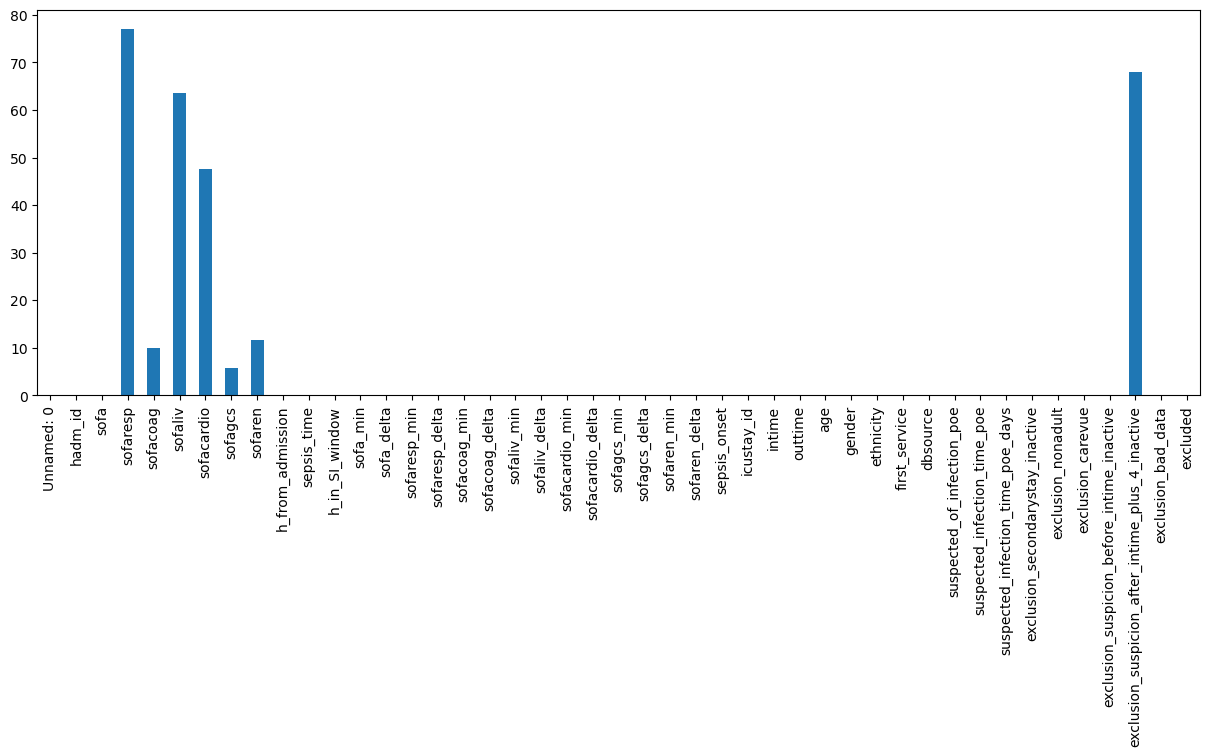

In [20]:
round(100*(df.isnull().sum()/len(df.index)),2).plot.bar(figsize=(15,5))

###### normalize/standardize

In [37]:
# Impute missing values for columns with a low percentage of missing data
imputer_num = SimpleImputer(strategy='mean')
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
# Impute missing values for numerical columns
df[num_cols] = imputer_num.fit_transform(df[num_cols])

In [ ]:
# Standardize numerical features
df[num_cols] = StandardScaler().fit_transform(df[num_cols])

In [38]:
#  imputation and standardization result 
print(df[num_cols].head())

    hadm_id  sofa  sofaresp  sofacoag  sofaliv  sofacardio  sofagcs  sofaren  \
0  100003.0   3.0  2.044858       0.0      2.0    1.047866      0.0      1.0   
1  100003.0   4.0  2.044858       0.0      2.0    1.000000      0.0      1.0   
2  100003.0   6.0  2.044858       1.0      2.0    1.000000      1.0      1.0   
3  100003.0   8.0  2.044858       1.0      2.0    3.000000      1.0      1.0   
4  100003.0   8.0  2.044858       1.0      2.0    3.000000      1.0      1.0   

   h_from_admission  h_in_SI_window  sofa_min  sofa_delta  sofaresp_min  \
0               0.0            -1.0       3.0         0.0           0.0   
1               1.0             0.0       3.0         1.0           0.0   
2               2.0             1.0       3.0         3.0           0.0   
3               3.0             2.0       3.0         5.0           0.0   
4               4.0             3.0       3.0         5.0           0.0   

   sofaresp_delta  sofacoag_min  sofacoag_delta  sofaliv_min  sofali

In [23]:
df = df.drop('Unnamed: 0', axis=1)

In [25]:
df.shape

(1033007, 44)

In [27]:
# Converting datetime columns from object to datatime 
for c in ['intime','outtime','sepsis_time'
         'suspected_infection_time',
          'suspected_infection_time_poe', 'blood_culture_time']: 
    if c in df.columns:
        if df[c].dtype == 'object':
            df[c] = pd.to_datetime(df[c])

- The missing values for numerical columns is imputed using the mean, and the features have been standardized.
This process ensures that all numerical features have a mean of 0 and a standard deviation of 1, which is crucial for many machine learning models.
- We changed datatypes 

###### Feature Engineering
Creating new features that might be relevant for predicting sepsis


In [ ]:
# Ratio of respiratory rate to heart rate as a potential indicator
df['resp_to_heart_rate_ratio'] = df['sofaresp'] / df['sofacardio']
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute any new missing values resulted from new feature creation
df['resp_to_heart_rate_ratio'] = imputer_num.fit_transform(df[['resp_to_heart_rate_ratio']])

print('New features created and missing values handled.')
print(df[['delta_sofa', 'resp_to_heart_rate_ratio']].head())

In [35]:
# Add some useful variables
df['suspicion_poe'] = (~df['suspected_infection_time_poe_days'].isnull())
df['sepsis-3'] = ((df['suspicion_poe'] == 1) & (df['sofa'] >= 2)).astype(int)
df['sofa>=2'] = (df['sofa'] >= 2).astype(int)

Adapted code applied successfully.


In [33]:
# Calculate the LOS in days
df['los'] = df.apply(lambda x: relativedelta(x['outtime'], x['intime']).days, axis=1)

New features have been successfully created and any resulting missing values have been handled. 

### Exploratory Data Analysis

In [43]:
#total no:of patients
len(pd.unique(df['icustay_id']))

32501

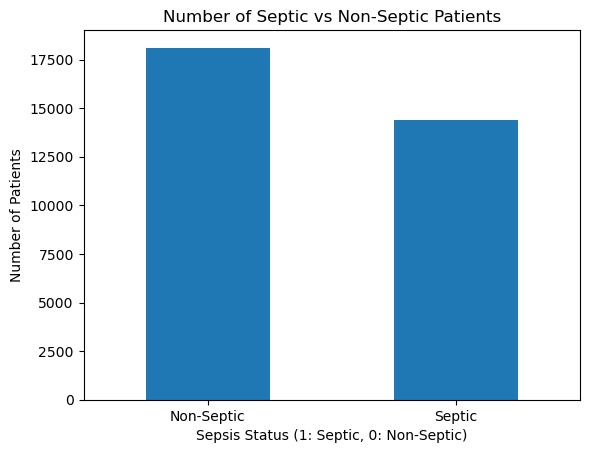

In [57]:
patient_sepsis_status = df.groupby('icustay_id')['sepsis_onset'].max()
sepsis_counts = patient_sepsis_status.value_counts()
sepsis_counts.plot(kind='bar')
plt.title('Number of Septic vs Non-Septic Patients')
plt.xlabel('Sepsis Status (1: Septic, 0: Non-Septic)')
plt.ylabel('Number of Patients')
plt.xticks(ticks=[0, 1], labels=['Non-Septic', 'Septic'], rotation=0)  # Adjust for clarity
plt.show()

In [65]:
df[['gender', 'sepsis_onset']].groupby(['gender']).mean()

sepsis_onset
gender              
F           0.305104
M           0.322883

In [67]:
df['gender'] = df['gender'].map({'M': 1, 'F': 0})

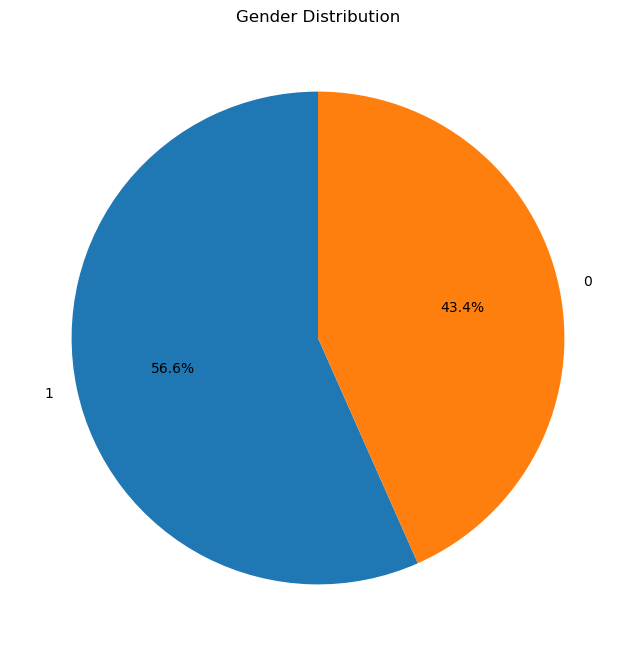

In [68]:
gender_counts = df['gender'].value_counts()
plt.figure(figsize=(8, 8))
gender_counts.plot.pie(autopct='%1.1f%%', startangle=90, labels=gender_counts.index)
plt.title('Gender Distribution')
plt.ylabel('')  
plt.show()

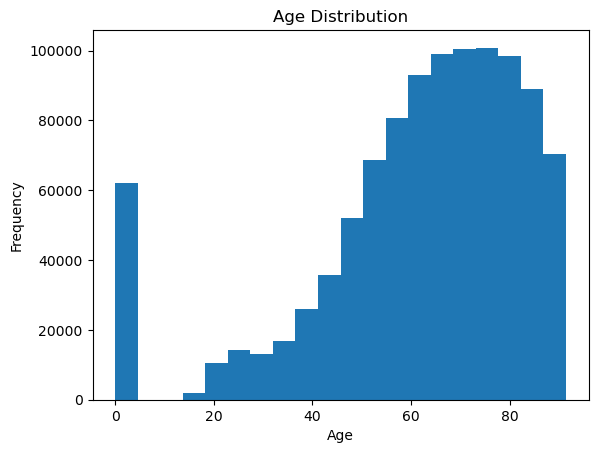

In [41]:
# Plot the distribution of ages
df['age'].hist(bins=20)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

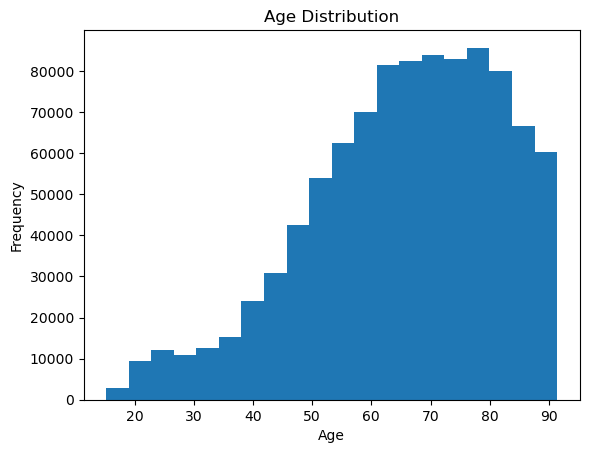

In [48]:
# Plot the distribution of new age >14
df['age'].hist(bins=20)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

C:\Users\amr_e\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


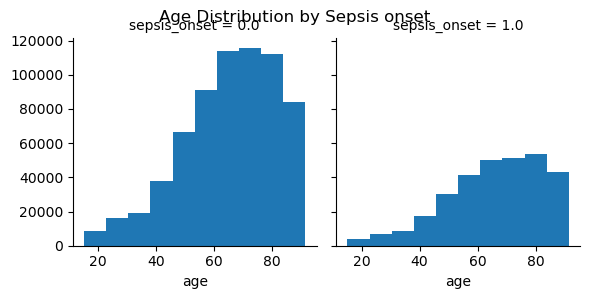

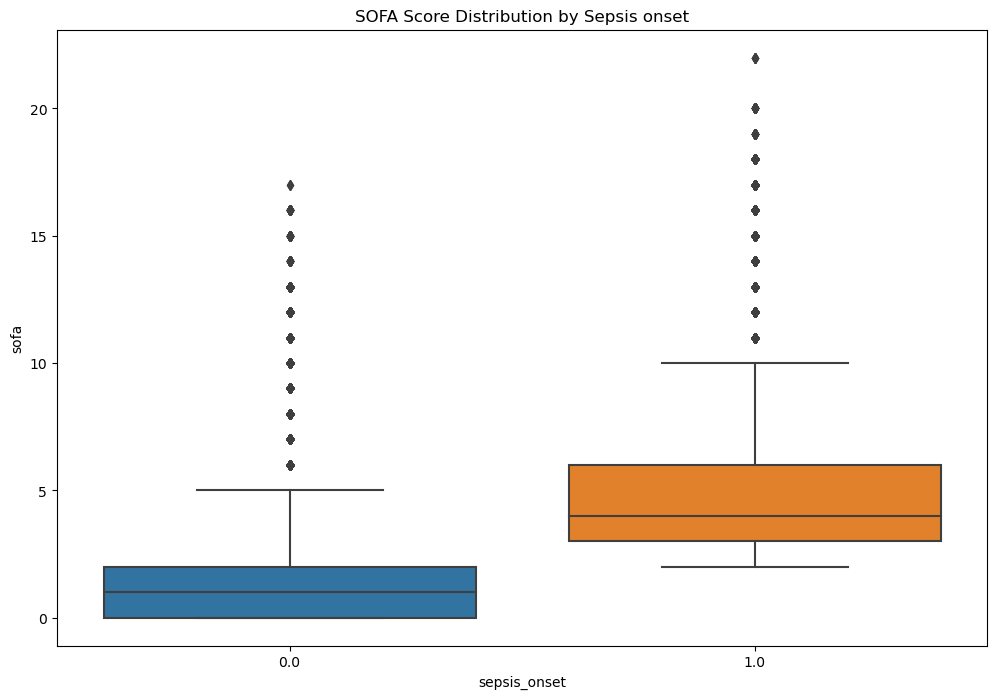

In [51]:
g = sns.FacetGrid(df, col='sepsis_onset')
g.map(plt.hist, 'age')
plt.suptitle('Age Distribution by Sepsis onset', verticalalignment='top')

# SOFA Score Distribution for Sepsis and Non-Sepsis Cases
plt.figure(figsize=(12, 8))
sns.boxplot(x='sepsis_onset', y='sofa', data=df)
plt.title('SOFA Score Distribution by Sepsis onset')

plt.show()

In [60]:
variables = ['sofa', 'sofaresp', 'sofacoag','sofaliv', 'sofacardio', 'sofagcs', 'sofaren', 'sofa_delta']

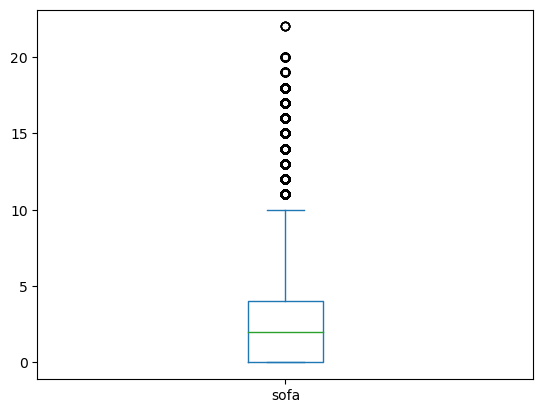

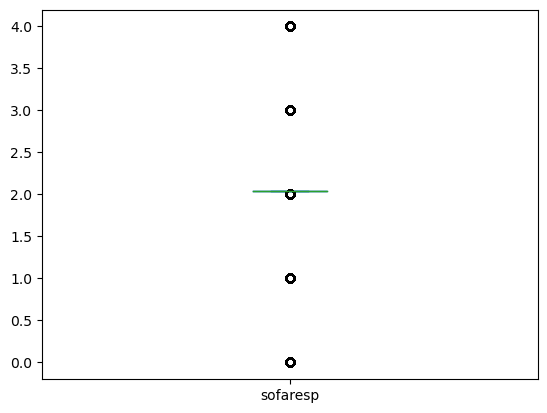

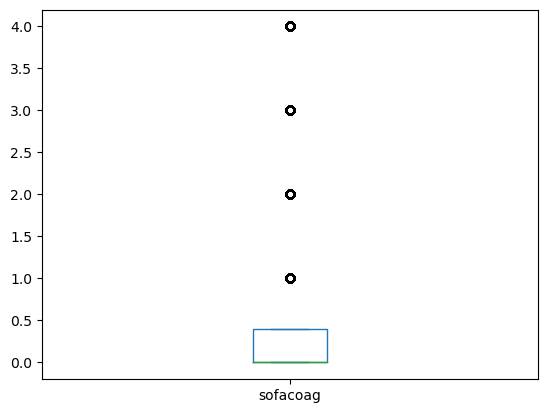

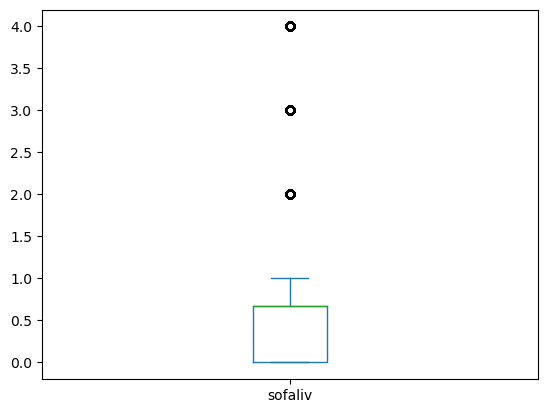

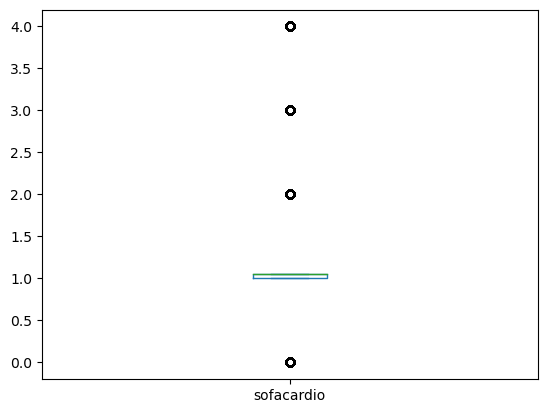

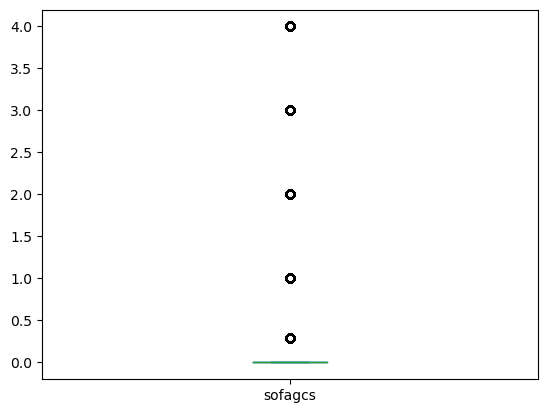

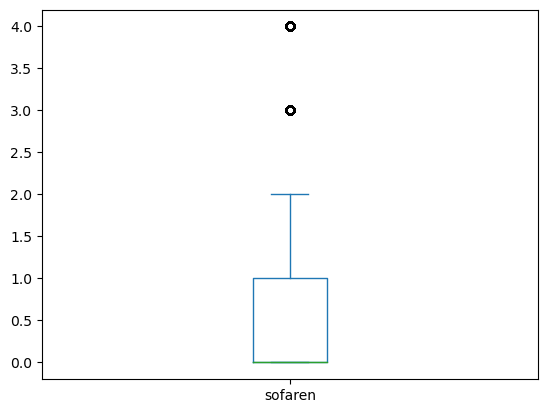

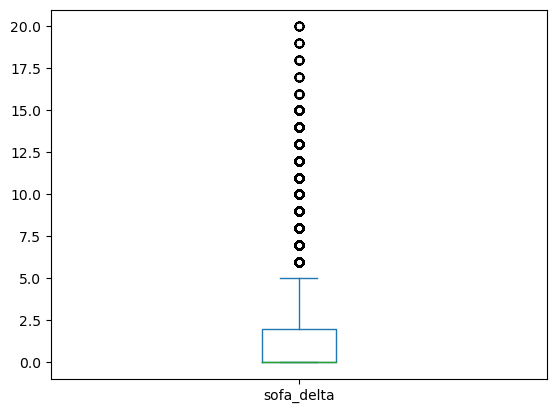

In [61]:
for variable in df[variables]:
    df[variable].plot.box()
    plt.xticks(ticks=[1], labels=[variable])  
    plt.show()

<Axes: >

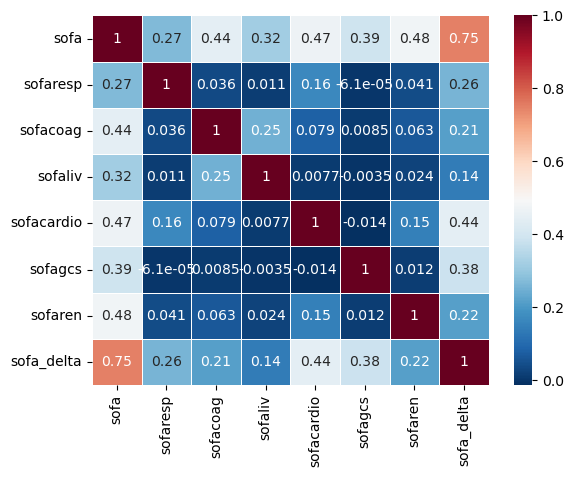

In [64]:
Corr_list = df[['sofa', 'sofaresp', 'sofacoag','sofaliv', 'sofacardio', 'sofagcs', 'sofaren', 'sofa_delta']]
vitalscorr = Corr_list.corr(method ='pearson')
sns.heatmap(vitalscorr, xticklabels=vitalscorr.columns, yticklabels=vitalscorr.columns, cmap='RdBu_r', annot=True, linewidth=0.5)

C:\Users\amr_e\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


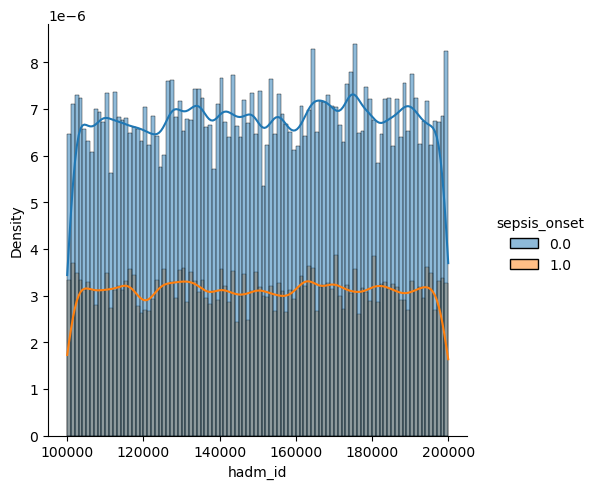

C:\Users\amr_e\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


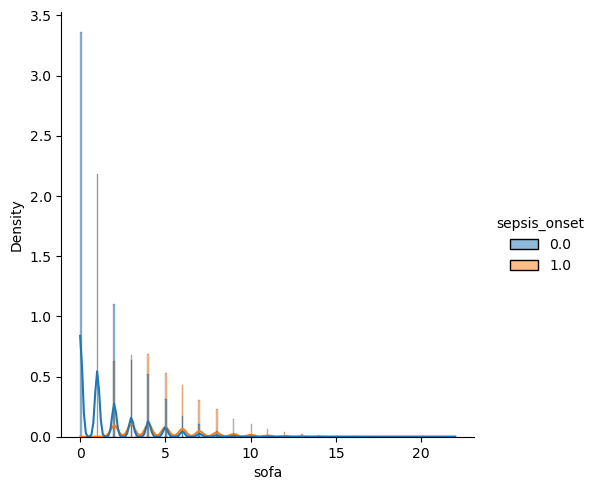

C:\Users\amr_e\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


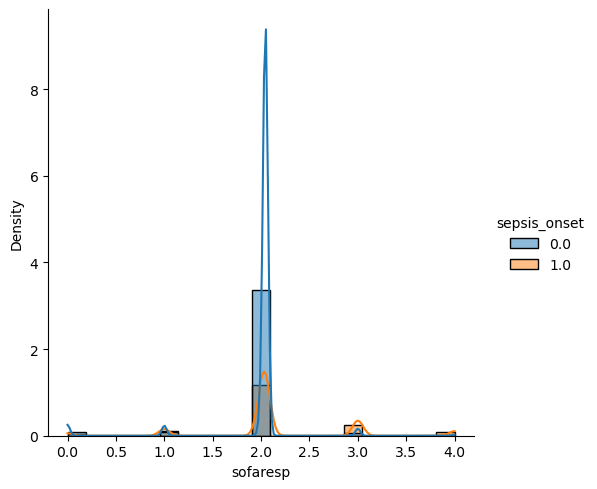

C:\Users\amr_e\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


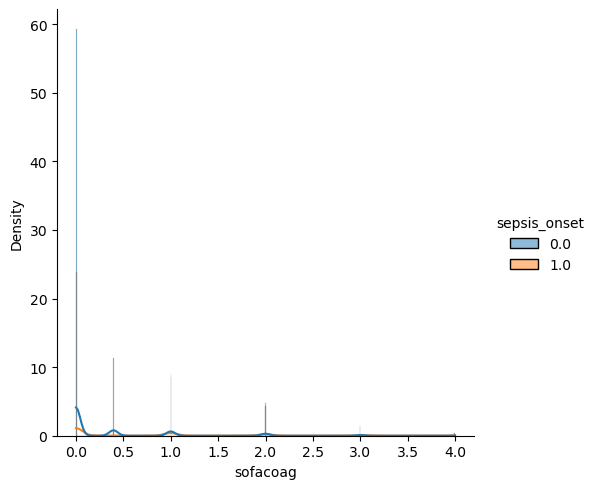

C:\Users\amr_e\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


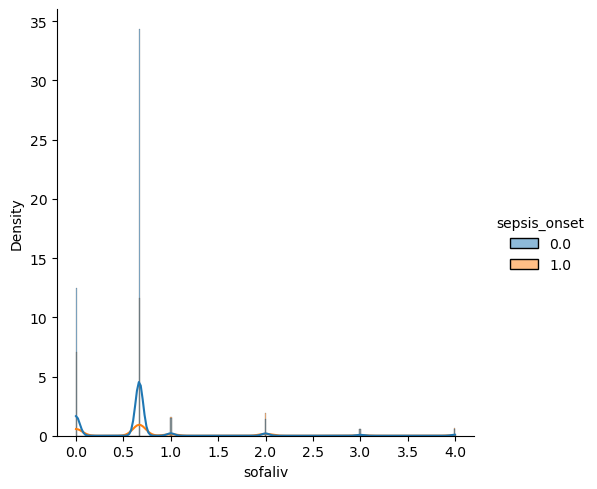

C:\Users\amr_e\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


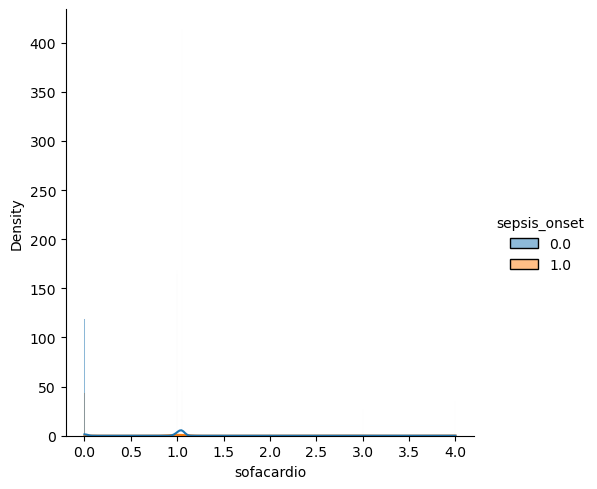

C:\Users\amr_e\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


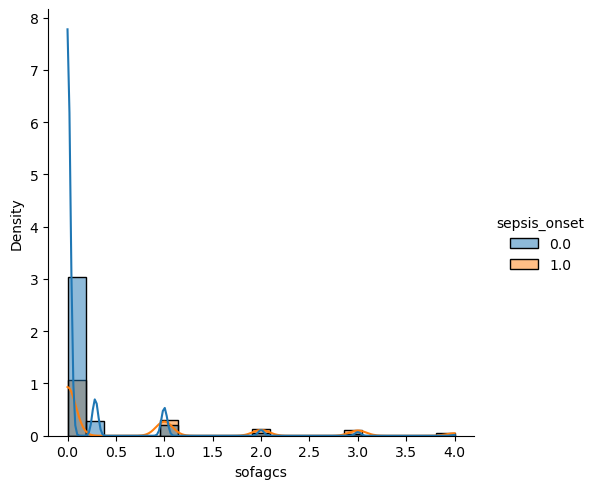

C:\Users\amr_e\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


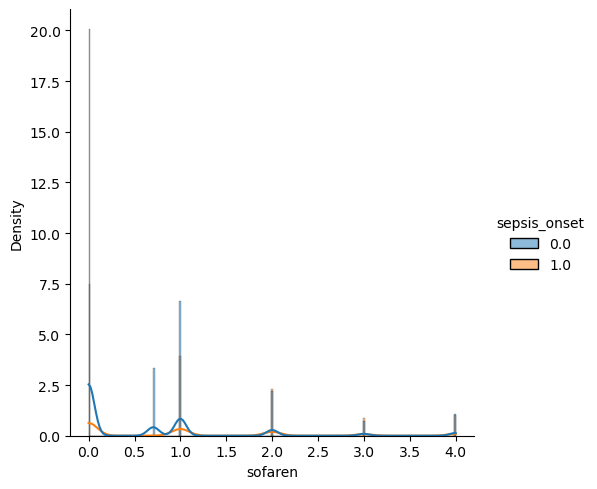

C:\Users\amr_e\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


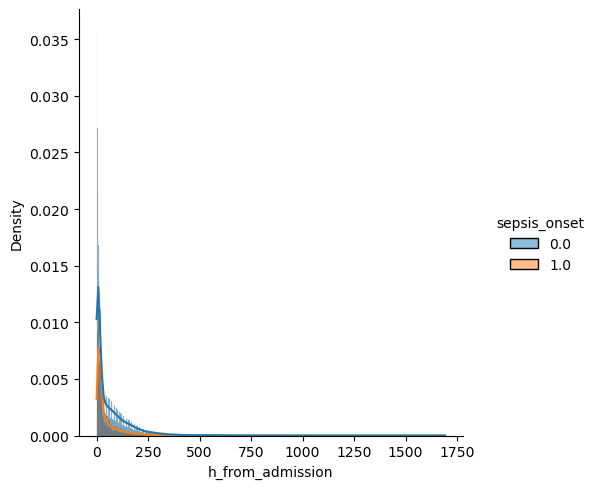

C:\Users\amr_e\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


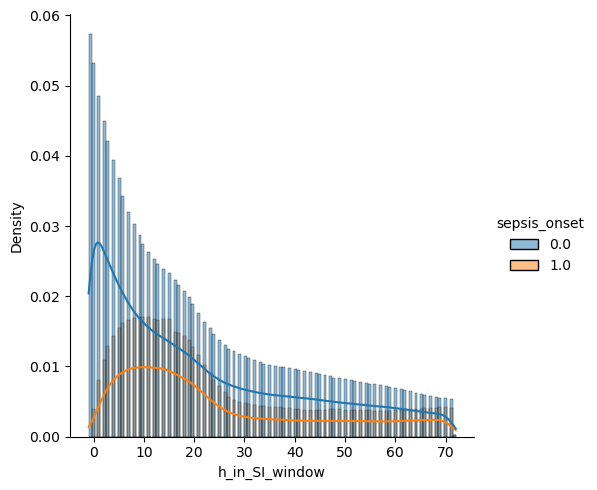

C:\Users\amr_e\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


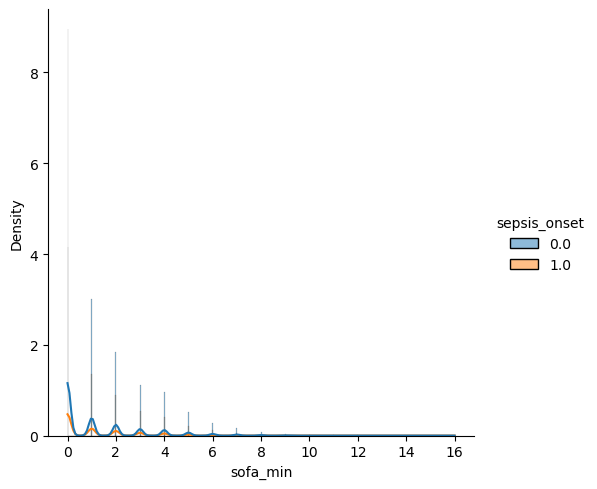

C:\Users\amr_e\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


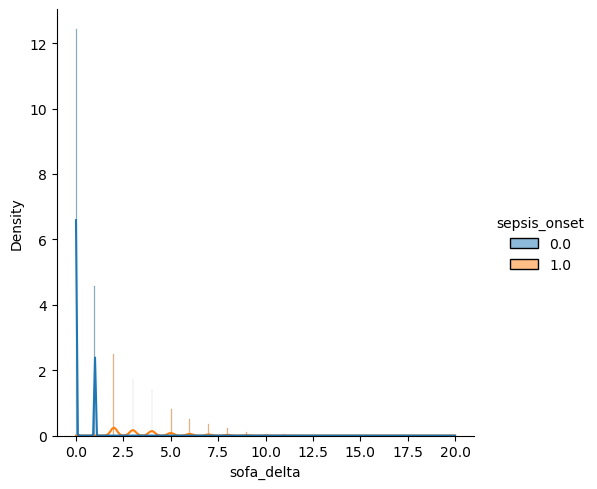

C:\Users\amr_e\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


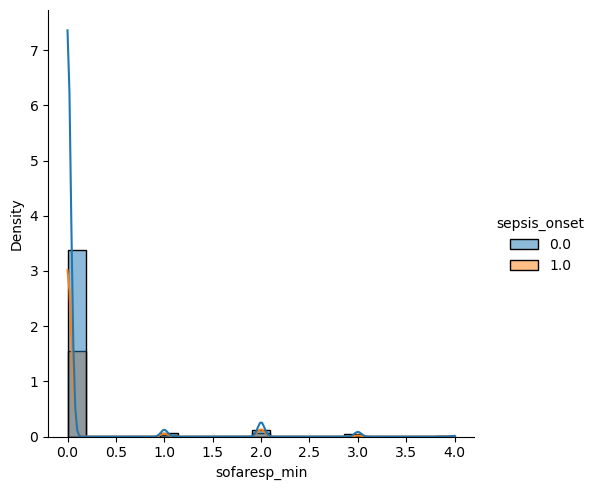

C:\Users\amr_e\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


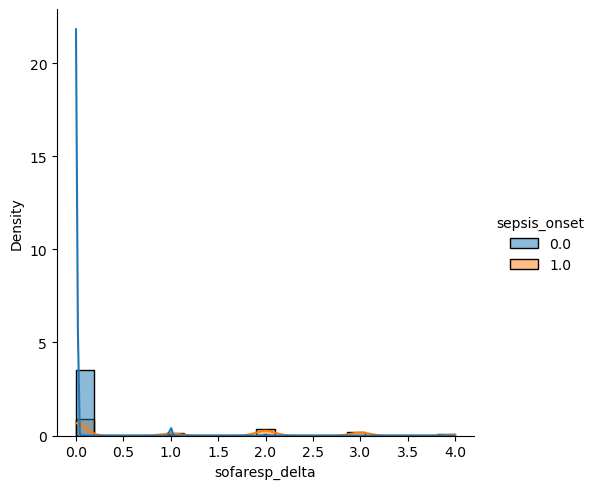

C:\Users\amr_e\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


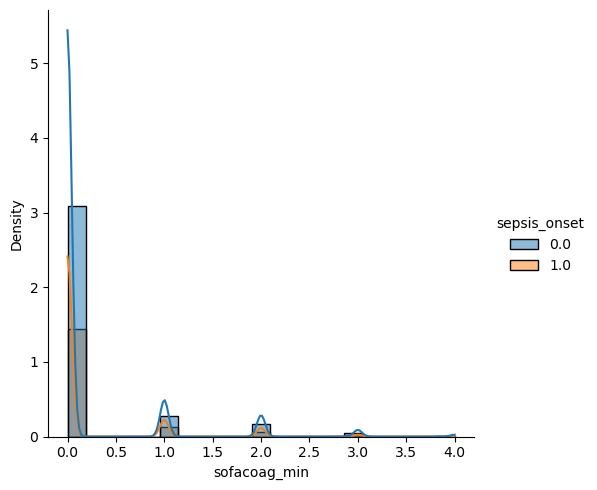

C:\Users\amr_e\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


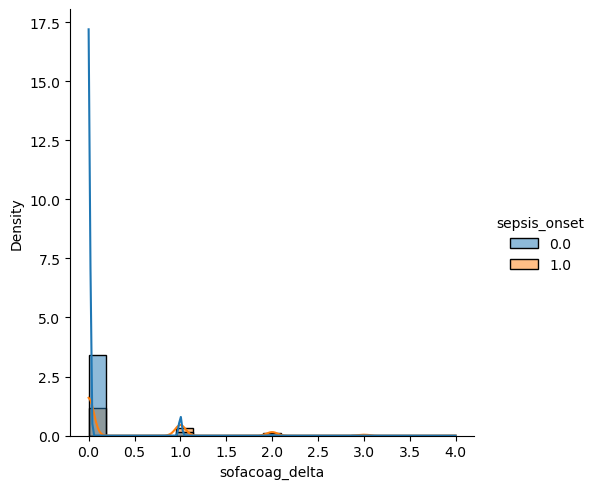

C:\Users\amr_e\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


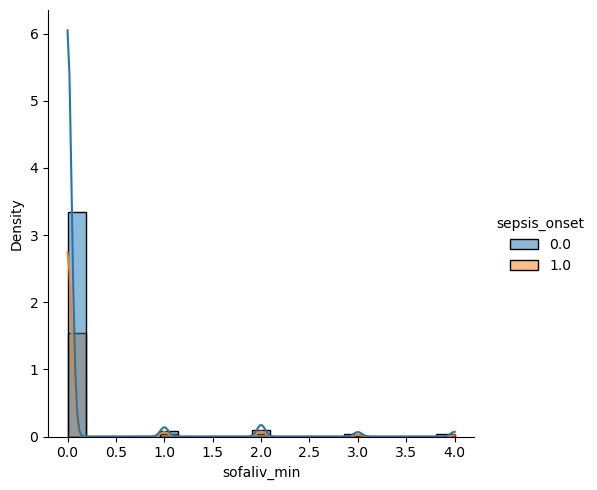

C:\Users\amr_e\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


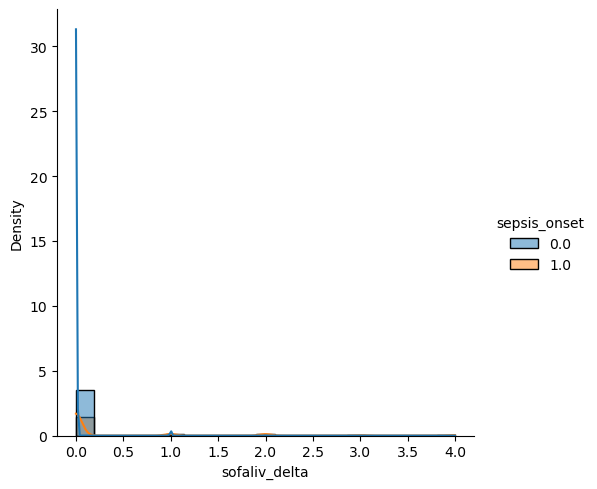

C:\Users\amr_e\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


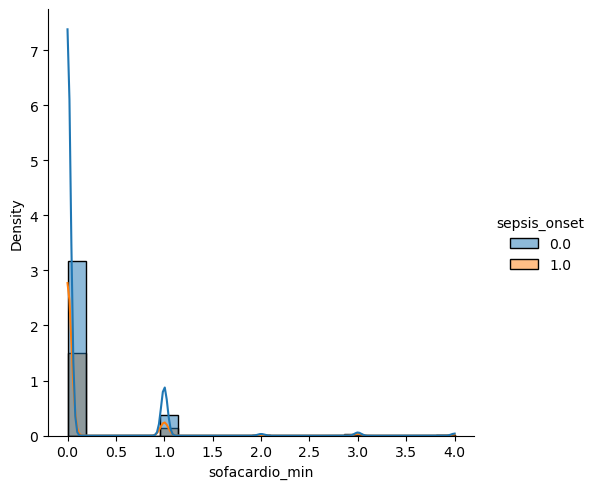

C:\Users\amr_e\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


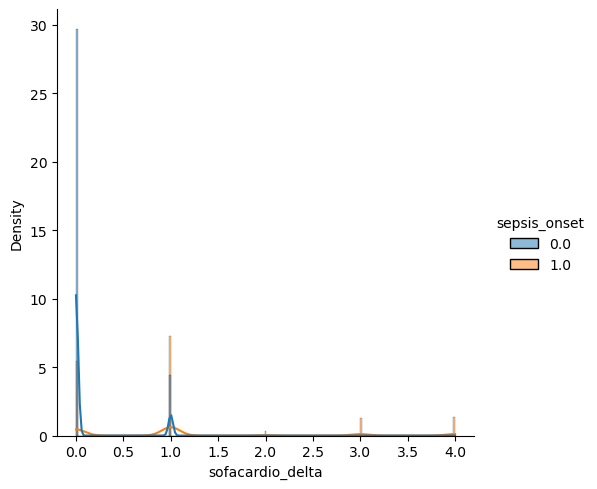

C:\Users\amr_e\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


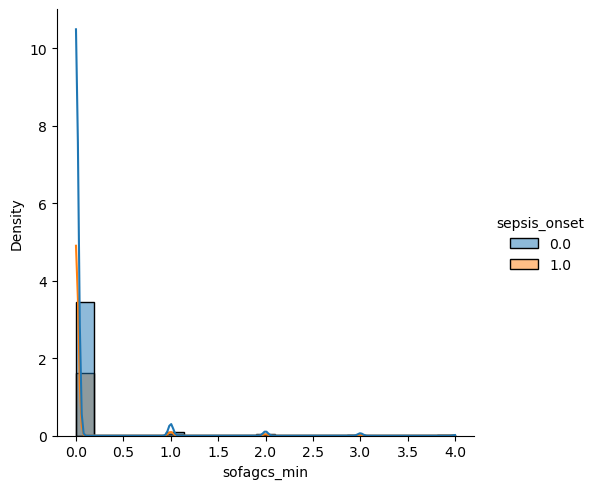

C:\Users\amr_e\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


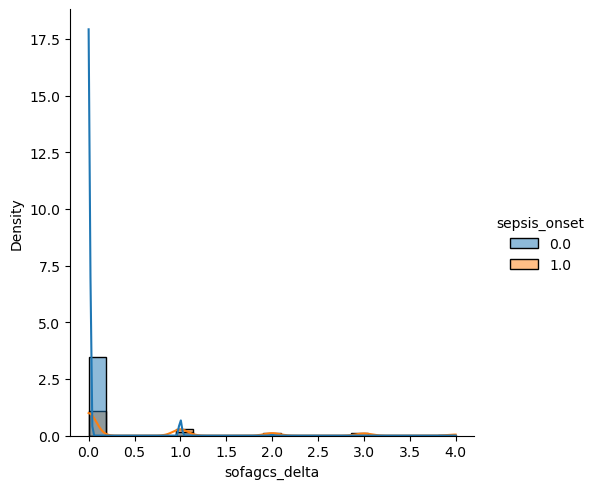

C:\Users\amr_e\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


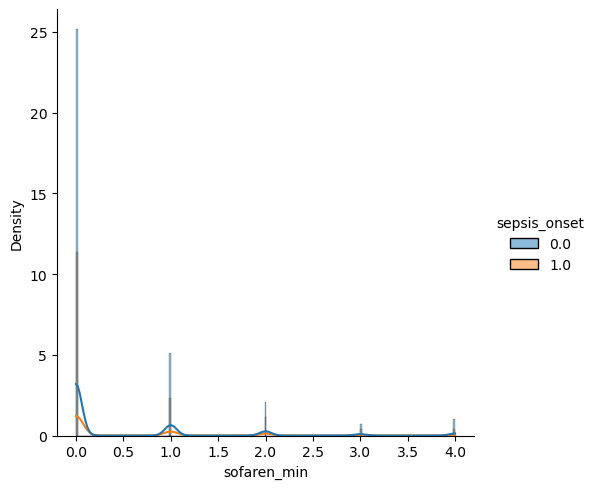

C:\Users\amr_e\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


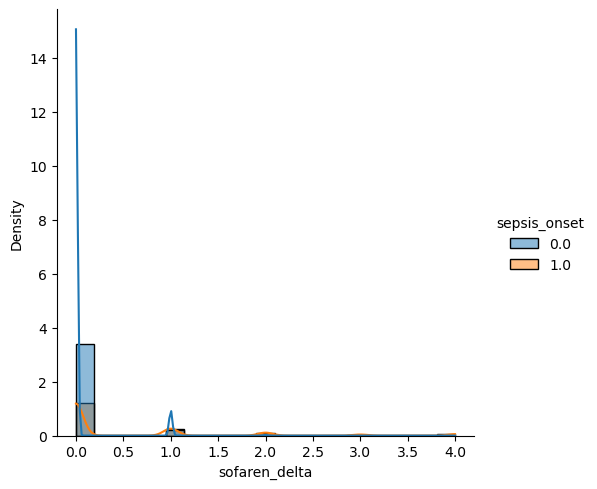

C:\Users\amr_e\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


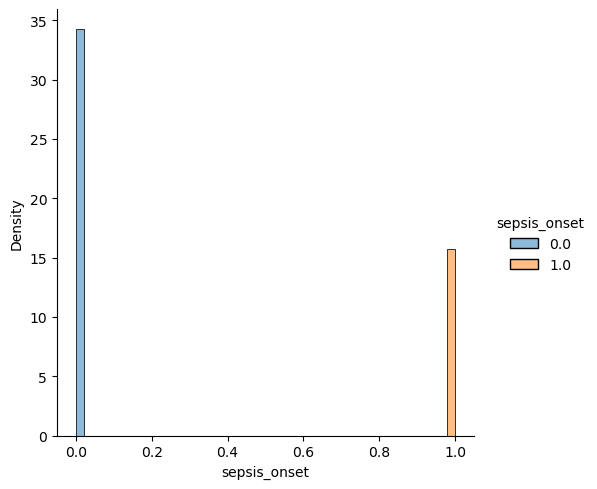

C:\Users\amr_e\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


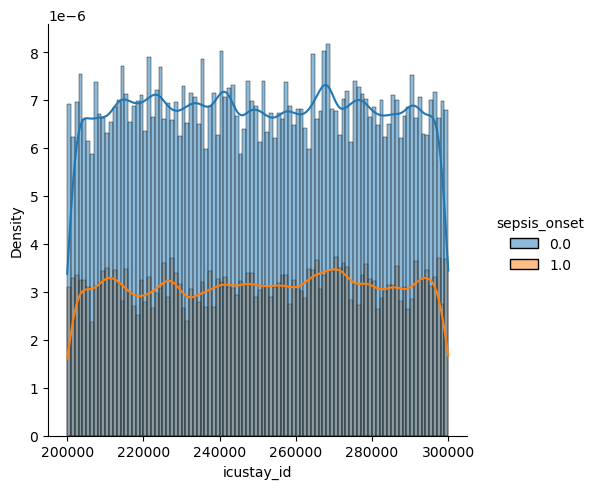

C:\Users\amr_e\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


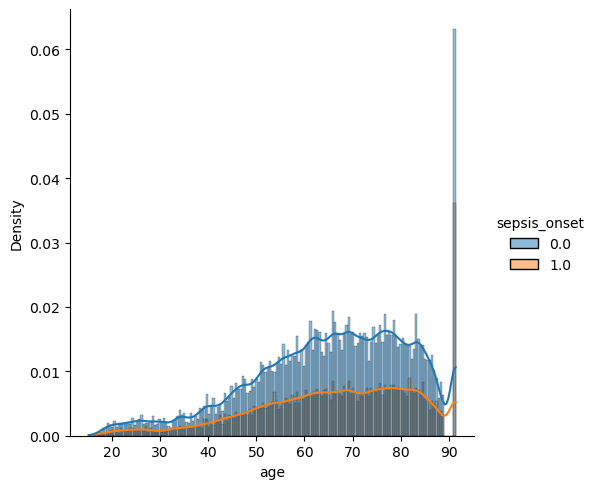

LinAlgError: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

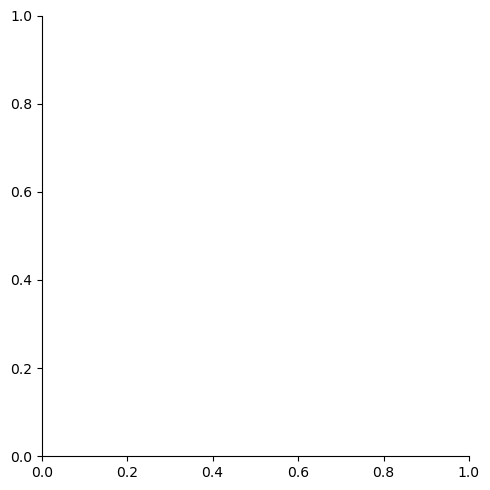

In [66]:
numerical_features =df.select_dtypes(include=['number'])

for col_name in numerical_features:
    sns.displot(data=df, x=col_name, hue='sepsis_onset', stat='density', kde=True)
    plt.show()

### Modeling

In [69]:
# Save the sampled DataFrame to a CSV file
df.to_csv('D:/Mostafa/Mimic/SofaMimic.csv', index=False)  # Adjust the path as needed

##### Set The Target

In [70]:

df['sepsis_onset_shifted'] = df.groupby('hadm_id')['sepsis_onset'].shift(-8).fillna(0)
# Display the first few rows to verify the shift
print(df[['hadm_id', 'h_from_admission', 'sepsis_onset', 'sepsis_onset_shifted']].head(15))

     hadm_id  h_from_admission  sepsis_onset  sepsis_onset_shifted
0   100003.0               0.0           0.0                   1.0
1   100003.0               1.0           0.0                   0.0
2   100003.0               2.0           1.0                   0.0
3   100003.0               3.0           1.0                   0.0
4   100003.0               4.0           1.0                   0.0
5   100003.0               5.0           1.0                   0.0
6   100003.0               6.0           1.0                   0.0
7   100003.0               7.0           1.0                   0.0
8   100003.0               8.0           1.0                   0.0
9   100006.0               0.0           0.0                   0.0
10  100006.0               1.0           0.0                   0.0
11  100006.0               2.0           0.0                   0.0
12  100006.0               3.0           0.0                   0.0
13  100006.0               4.0           0.0                  

##### selecting the cohert
since we are prediction 8 hours before sepsis_onset , we will drop h_from_admission<9 

In [72]:
# Dropping patients with 'h_from_admission' < 9
df_filtered = df[df['h_from_admission'] >= 9]

# Displaying the shape of the original and filtered dataframes to see how many rows were dropped
original_shape = df.shape
filtered_shape = df_filtered.shape

print('Original dataframe shape:', original_shape)
print('Filtered dataframe shape:', filtered_shape)

Original dataframe shape: (971054, 50)
Filtered dataframe shape: (740921, 50)


In [73]:
df=df_filtered

In [84]:
features_list =[
    "sofa", "sofaresp", "sofacoag", "sofaliv", "sofacardio", "sofagcs", "sofaren", 
    "h_from_admission", "h_in_SI_window", "sofa_min", "sofa_delta", "sofaresp_min", 
    "sofaresp_delta", "sofacoag_min", "sofacoag_delta", "sofaliv_min", "sofaliv_delta", 
    "sofacardio_min", "sofacardio_delta", "sofagcs_min", "sofagcs_delta", "sofaren_min", 
    "sofaren_delta",
]
len(features_list)

23

Let's start with splitting the data into training and testing sets.
We'll use a 70-30 split for this purpose.
After splitting, we'll proceed with feature selection based on correlation analysis.

In [85]:
from sklearn.model_selection import train_test_split

# Define the features and target variable
X = df[features_list] 
y = df['sepsis_onset_shifted']

# Split the data into training and testing sets (70-30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Display the shapes of the training and testing sets to confirm the split
print('Training set shape:', X_train.shape, y_train.shape)
print('Testing set shape:', X_test.shape, y_test.shape)

Training set shape: (518644, 23) (518644,)
Testing set shape: (222277, 23) (222277,)


we proceed with feature selection to identify the most relevant features for predicting sepsis.
This step involves analyzing the correlation between features and the target variable to select those with the highest predictive power.

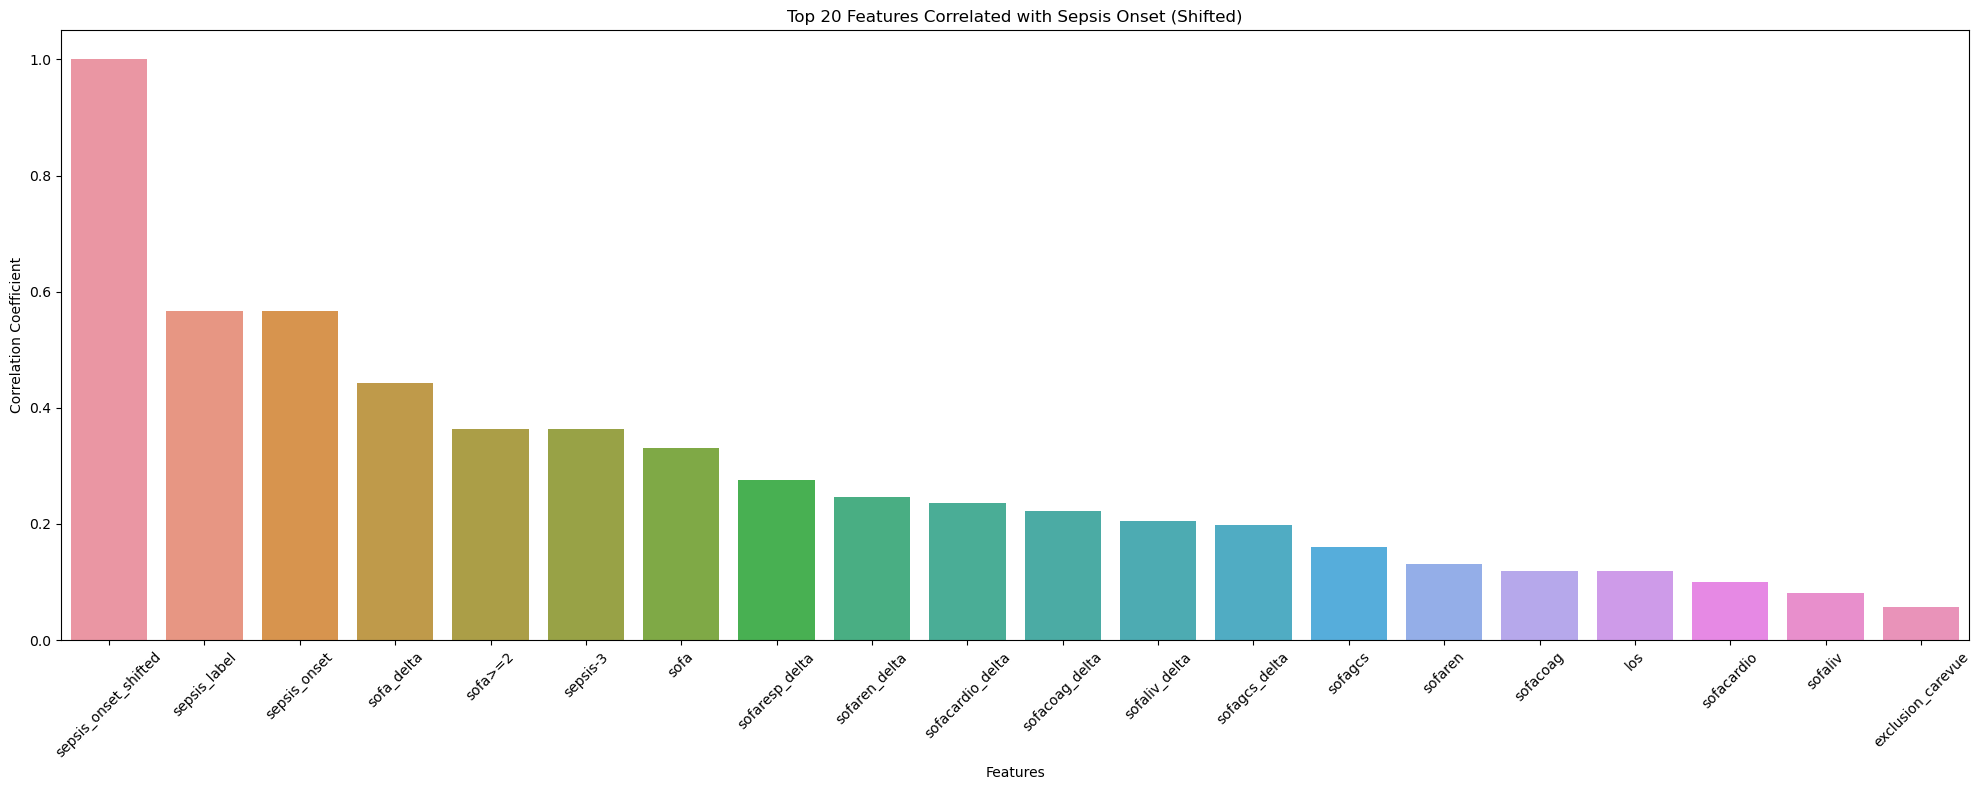

In [81]:
# Convert categorical columns to numeric if needed (one-hot encoding, label encoding, etc.), or exclude them
imputer = SimpleImputer(strategy='mean')

df_numeric = df.select_dtypes(include=[np.number])  

# Calculate the correlation matrix on the numeric DataFrame
corr_matrix = df_numeric.corr()

target_corr = corr_matrix['sepsis_onset_shifted'].sort_values(ascending=False)
# Plot the correlations of the top 10 features with the target variable
plt.figure(figsize=(20, 8))
sns.barplot(x=target_corr.index[:20], y=target_corr.values[:20])
plt.xticks(rotation=45)
plt.title('Top 20 Features Correlated with Sepsis Onset (Shifted)')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.tight_layout()
plt.show()

### Random Forest

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training set
rf_classifier.fit(X_train, y_train)

# Predict on the testing set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.8961386018346478
Precision: 0.818879293030729
Recall: 0.7434719183078046
F1 Score: 0.7793558252891141


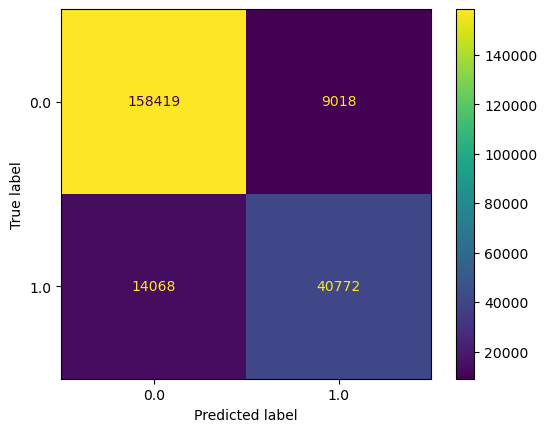

In [90]:
ConfusionMatrixDisplay.from_estimator(rf_classifier, X_test, y_test, values_format = 'd')
plt.show()

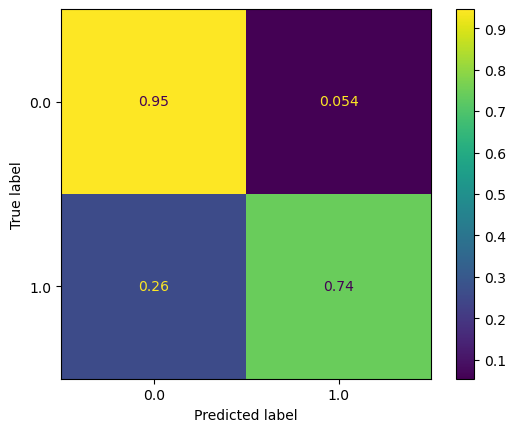

In [92]:
ConfusionMatrixDisplay.from_estimator(rf_classifier, X_test, y_test, normalize = 'true')
plt.show()

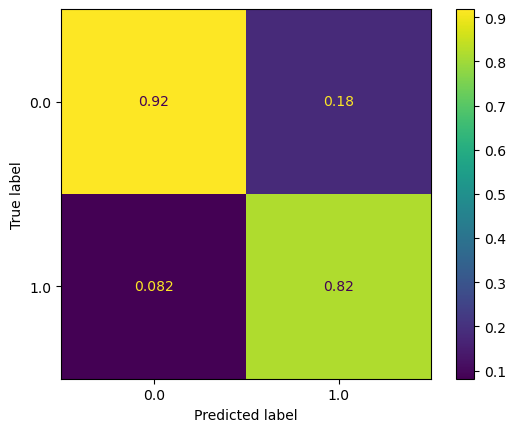

In [93]:
# precision-related metrics 
ConfusionMatrixDisplay.from_estimator(rf_classifier, X_test, y_test, normalize = 'pred')
plt.show()

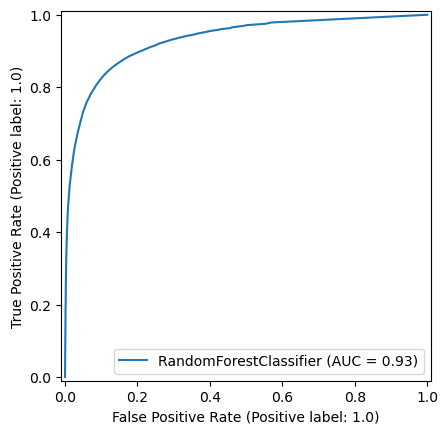

In [94]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(rf_classifier, X_test, y_test) 
plt.show()

These metrics indicate how well the Random Forest classifier performed on the testing set after imputing missing values.
The accuracy is relatively high, suggesting that the model is capable of correctly identifying the majority of the cases. However, the precision, recall, and F1 score are lower, indicating room for improvement, especially in correctly predicting positive cases of sepsis onset. 
This suggests that while the model is generally reliable, it may struggle with balancing false positives and false negatives, which is critical in a medical context like sepsis prediction.

### Pytorch

In [119]:

# Scaling the preprocessed data without the excluded columns
scaler = StandardScaler()
X_final = df[features_list] 
y_final = df['sepsis_onset_shifted']
X_scaled_final = scaler.fit_transform(X_final)

# Splitting the dataset into training and testing sets
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_scaled_final, y_final, test_size=0.2, random_state=42)


In [120]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Converting data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_final, dtype=torch.float)
X_test_tensor = torch.tensor(X_test_final, dtype=torch.float)
y_train_tensor = torch.tensor(y_train_final.values, dtype=torch.float)
y_test_tensor = torch.tensor(y_test_final.values, dtype=torch.float)

# Creating datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Defining the neural network architecture
class SepsisNet(nn.Module):
    def __init__(self):
        super(SepsisNet, self).__init__()
        self.fc1 = nn.Linear(X_train_final.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Initializing the model, loss function, and optimizer
model = SepsisNet()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print('Model, criterion, and optimizer initialized. Ready for training.')

Model, criterion, and optimizer initialized. Ready for training.


In [121]:
# Training the model
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Evaluating the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = correct / total
print(f'Test Accuracy: {accuracy}')

Epoch 1/10, Loss: 0.6462528705596924
Epoch 2/10, Loss: 0.6351223587989807
Epoch 3/10, Loss: 0.655082106590271
Epoch 4/10, Loss: 0.7077249884605408
Epoch 5/10, Loss: 0.6872043609619141
Epoch 6/10, Loss: 0.6033715009689331
Epoch 7/10, Loss: 0.6698887348175049
Epoch 8/10, Loss: 0.6689481735229492
Epoch 9/10, Loss: 0.6035925149917603
Epoch 10/10, Loss: 0.6489576101303101
Test Accuracy: 0.8542497553733509


The training process of the SepsisNet model over 10 epochs showed a decreasing trend in loss, indicating that the model was learning from the training data. Here are the loss values for the first and last epochs:

Epoch 1 Loss: Epoch 1/10, Loss: 0.6462528705596924

Epoch 10 Loss: Epoch 10/10, Loss: 0.6489576101303101

The test accuracy achieved by the model is:

Test Accuracy:  0.8542497553733509